IMPORT LIBRARIES

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import spacy
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import SelfTrainingClassifier
import re
from itertools import combinations
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import spacy.cli

# Define the path in Google Drive to save the model
model_path = '/content/drive/MyDrive/Metaphor Detector'

# Change directory to the specified path
%cd $model_path

# Download the en_core_web_lg model directly to the current directory
spacy.cli.download('en_core_web_lg')

/content/drive/MyDrive/Metaphor Detector
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
nlp = spacy.load('en_core_web_lg')

In [7]:
# Function for preprocessing text
def preprocess_text(text):
    # Tokenization, lowercasing, lemmatization
    doc = nlp(text)
    preprocessed_tokens = []
    for token in doc:
        # Ignore tokens that are punctuation or whitespace
        if not token.is_punct and not token.is_space:
            # Lemmatize token and convert to lowercase
            preprocessed_token = token.lemma_.lower()
            preprocessed_tokens.append(preprocessed_token)
    return preprocessed_tokens

In [8]:
# Load labeled dataset from CSV file

unlabeled_file_path = "//content//drive//MyDrive//Metaphor Detector//data.csv"
df_labeled = pd.read_csv(unlabeled_file_path, encoding='ISO-8859-1')

In [9]:
df_labeled.shape

(509, 5)

In [10]:
df_labeled.head()

,Excerpt,HPSM,LPSM,Concepts,Label
0,We shall not be visited by the vulture.,death,"corpse, carcass","visit, vulture",1
1,"Turn, turn, turn; the world knows little, of t...",passing time,moment,"sun, huge mask",1
2,You are standing strong like the lobelia tree.,"slim, strong, obsolete",but direct comparison,"strong, lobelia tree",0
3,hush says the panting gun,threat,readiness,"pant, gun",1
4,pour the white chalk on the floor,consult the oracle,voodoo,"chalk, floor",1


In [11]:
df_labeled.Label.value_counts()

Label
1    255
0    254
Name: count, dtype: int64

In [12]:
# Preprocess 'Excerpt' column
preprocessed_excerpt = []
for text in df_labeled['Excerpt']:
    preprocessed_text = preprocess_text(str(text))
    preprocessed_excerpt.append(preprocessed_text)
df_labeled['Preprocessed_Excerpt'] = preprocessed_excerpt

# Preprocess 'HPSM' column
preprocessed_hpsm = []
for text in df_labeled['HPSM']:
    preprocessed_text = preprocess_text(str(text))
    preprocessed_hpsm.append(preprocessed_text)
df_labeled['Preprocessed_HPSM'] = preprocessed_hpsm

# Preprocess 'LPSM' column
preprocessed_lpsm = []
for text in df_labeled['LPSM']:
    preprocessed_text = preprocess_text(str(text))
    preprocessed_lpsm.append(preprocessed_text)
df_labeled['Preprocessed_LPSM'] = preprocessed_lpsm

# Preprocess 'Concepts' column
preprocessed_concepts = []
for text in df_labeled['Concepts']:
    preprocessed_text = preprocess_text(str(text))
    preprocessed_concepts.append(preprocessed_text)
df_labeled['Preprocessed_Concepts'] = preprocessed_concepts



In [13]:
df_labeled.head()

,Excerpt,HPSM,LPSM,Concepts,Label,Preprocessed_Excerpt,Preprocessed_HPSM,Preprocessed_LPSM,Preprocessed_Concepts
0,We shall not be visited by the vulture.,death,"corpse, carcass","visit, vulture",1,"[we, shall, not, be, visit, by, the, vulture]",[death],"[corpse, carcass]","[visit, vulture]"
1,"Turn, turn, turn; the world knows little, of t...",passing time,moment,"sun, huge mask",1,"[turn, turn, turn, the, world, know, little, o...","[pass, time]",[moment],"[sun, huge, mask]"
2,You are standing strong like the lobelia tree.,"slim, strong, obsolete",but direct comparison,"strong, lobelia tree",0,"[you, be, stand, strong, like, the, lobelia, t...","[slim, strong, obsolete]","[but, direct, comparison]","[strong, lobelia, tree]"
3,hush says the panting gun,threat,readiness,"pant, gun",1,"[hush, say, the, pant, gun]",[threat],[readiness],"[pant, gun]"
4,pour the white chalk on the floor,consult the oracle,voodoo,"chalk, floor",1,"[pour, the, white, chalk, on, the, floor]","[consult, the, oracle]",[voodoo],"[chalk, floor]"


In [14]:
import re

# Regular expression to remove punctuation, whitespace, special symbols, and square brackets
def remove_symbols(text):
    if not isinstance(text, str):
        text = str(text)  # Convert to string if not already
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special symbols
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    text = text.strip()  # Remove leading and trailing whitespaces
    return text

# Apply the function to the newly created preprocessed columns
df_labeled['Preprocessed_Excerpt'] = df_labeled['Preprocessed_Excerpt'].apply(remove_symbols)
df_labeled['Preprocessed_HPSM'] = df_labeled['Preprocessed_HPSM'].apply(remove_symbols)
df_labeled['Preprocessed_LPSM'] = df_labeled['Preprocessed_LPSM'].apply(remove_symbols)
df_labeled['Preprocessed_Concepts'] = df_labeled['Preprocessed_Concepts'].apply(remove_symbols)


In [15]:
df_labeled.head()

,Excerpt,HPSM,LPSM,Concepts,Label,Preprocessed_Excerpt,Preprocessed_HPSM,Preprocessed_LPSM,Preprocessed_Concepts
0,We shall not be visited by the vulture.,death,"corpse, carcass","visit, vulture",1,we shall not be visit by the vulture,death,corpse carcass,visit vulture
1,"Turn, turn, turn; the world knows little, of t...",passing time,moment,"sun, huge mask",1,turn turn turn the world know little of the de...,pass time,moment,sun huge mask
2,You are standing strong like the lobelia tree.,"slim, strong, obsolete",but direct comparison,"strong, lobelia tree",0,you be stand strong like the lobelia tree,slim strong obsolete,but direct comparison,strong lobelia tree
3,hush says the panting gun,threat,readiness,"pant, gun",1,hush say the pant gun,threat,readiness,pant gun
4,pour the white chalk on the floor,consult the oracle,voodoo,"chalk, floor",1,pour the white chalk on the floor,consult the oracle,voodoo,chalk floor


In [16]:
# Concatenate the specified columns into one
df_labeled['Concatenated_Column'] = df_labeled.apply(lambda row: ' '.join(row[col] for col in ['Preprocessed_Excerpt', 'Preprocessed_HPSM', 'Preprocessed_LPSM', 'Preprocessed_Concepts']), axis=1)


In [18]:
df_labeled.head()

,Excerpt,HPSM,LPSM,Concepts,Label,Preprocessed_Excerpt,Preprocessed_HPSM,Preprocessed_LPSM,Preprocessed_Concepts,Concatenated_Column
0,We shall not be visited by the vulture.,death,"corpse, carcass","visit, vulture",1,we shall not be visit by the vulture,death,corpse carcass,visit vulture,we shall not be visit by the vulture death cor...
1,"Turn, turn, turn; the world knows little, of t...",passing time,moment,"sun, huge mask",1,turn turn turn the world know little of the de...,pass time,moment,sun huge mask,turn turn turn the world know little of the de...
2,You are standing strong like the lobelia tree.,"slim, strong, obsolete",but direct comparison,"strong, lobelia tree",0,you be stand strong like the lobelia tree,slim strong obsolete,but direct comparison,strong lobelia tree,you be stand strong like the lobelia tree slim...
3,hush says the panting gun,threat,readiness,"pant, gun",1,hush say the pant gun,threat,readiness,pant gun,hush say the pant gun threat readiness pant gun
4,pour the white chalk on the floor,consult the oracle,voodoo,"chalk, floor",1,pour the white chalk on the floor,consult the oracle,voodoo,chalk floor,pour the white chalk on the floor consult the ...


In [19]:
# Preprocess 'Concatenated_Column' column in labeled dataframe
df_labeled['vector'] = df_labeled['Concatenated_Column'].apply(lambda x: nlp(x).vector)

In [20]:
df_labeled.head()

,Excerpt,HPSM,LPSM,Concepts,Label,Preprocessed_Excerpt,Preprocessed_HPSM,Preprocessed_LPSM,Preprocessed_Concepts,Concatenated_Column,vector
0,We shall not be visited by the vulture.,death,"corpse, carcass","visit, vulture",1,we shall not be visit by the vulture,death,corpse carcass,visit vulture,we shall not be visit by the vulture death cor...,"[-1.1754014, 1.0364107, -2.3647585, -0.6126923..."
1,"Turn, turn, turn; the world knows little, of t...",passing time,moment,"sun, huge mask",1,turn turn turn the world know little of the de...,pass time,moment,sun huge mask,turn turn turn the world know little of the de...,"[-1.4409485, 1.9039226, -1.1193062, 0.95257866..."
2,You are standing strong like the lobelia tree.,"slim, strong, obsolete",but direct comparison,"strong, lobelia tree",0,you be stand strong like the lobelia tree,slim strong obsolete,but direct comparison,strong lobelia tree,you be stand strong like the lobelia tree slim...,"[-1.9812512, 1.2336799, -2.6391902, 0.9217006,..."
3,hush says the panting gun,threat,readiness,"pant, gun",1,hush say the pant gun,threat,readiness,pant gun,hush say the pant gun threat readiness pant gun,"[0.05845107, 1.8241553, -1.2987666, 3.3894205,..."
4,pour the white chalk on the floor,consult the oracle,voodoo,"chalk, floor",1,pour the white chalk on the floor,consult the oracle,voodoo,chalk floor,pour the white chalk on the floor consult the ...,"[-2.0350997, 0.85046077, -0.6495262, 1.6092461..."


In [21]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_labeled.vector, df_labeled.Label, test_size=0.2, random_state=42)


In [22]:
X_train

506    [-2.403146, 0.21876144, -4.270203, -0.08390001...
137    [-2.219847, 0.6064405, -0.1320046, -0.4399018,...
422    [-1.8773503, 1.3747079, -2.9350073, -1.482755,...
329    [0.15154359, 0.73016006, -3.761841, -1.5943861...
412    [-1.3558955, 1.2339629, -3.0244334, 0.28492734...
                             ...                        
106    [-1.4161358, 2.6366432, -2.4851356, 1.5675286,...
270    [-3.4221327, 2.5536618, -0.16033188, 0.6635672...
348    [-3.1178308, 0.77004206, -1.5684841, 1.2526964...
435    [-1.4888265, 0.84448135, -3.7411175, 0.3258095...
102    [-0.55989265, 2.9219298, -3.533337, -0.1366713...
Name: vector, Length: 407, dtype: object

In [23]:
X_train.shape

(407,)

In [24]:
X_test.shape

(102,)

In [25]:
y_train.shape

(407,)

In [26]:
y_test.shape

(102,)

In [27]:
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [28]:
X_train_2d

array([[-2.403146  ,  0.21876144, -4.270203  , ..., -1.8593495 ,
        -3.5774279 ,  1.345723  ],
       [-2.219847  ,  0.6064405 , -0.1320046 , ...,  0.9131    ,
        -3.3632035 ,  0.3524936 ],
       [-1.8773503 ,  1.3747079 , -2.9350073 , ..., -0.20494682,
        -4.2415786 ,  0.82713586],
       ...,
       [-3.1178308 ,  0.77004206, -1.5684841 , ..., -1.1195961 ,
        -1.6376541 ,  0.48140556],
       [-1.4888265 ,  0.84448135, -3.7411175 , ..., -1.0376185 ,
        -4.119795  , -0.12225001],
       [-0.55989265,  2.9219298 , -3.533337  , ..., -0.3085289 ,
        -5.1469364 ,  1.3089411 ]], dtype=float32)

---------- K Nearest Neighbors Classifier Model - Evaluation on Test Data ----------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        53
           1       0.91      0.86      0.88        49

    accuracy                           0.89       102
   macro avg       0.89      0.89      0.89       102
weighted avg       0.89      0.89      0.89       102



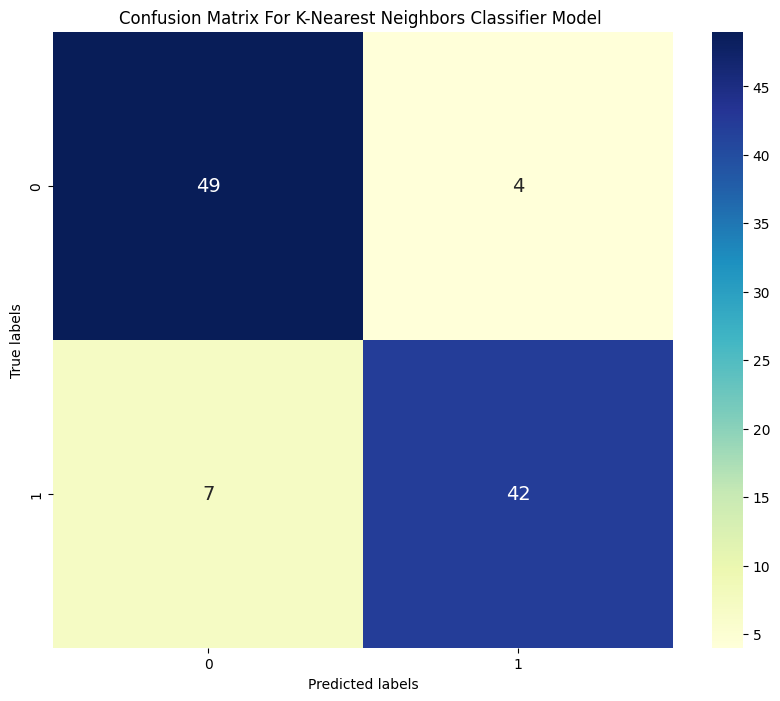

In [100]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Your KNN classifier code
clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
clf.fit(X_train_2d, y_train)
y_pred = clf.predict(X_test_2d)

print('---------- K Nearest Neighbors Classifier Model - Evaluation on Test Data ----------')
# Printing classification report
print(classification_report(y_test, y_pred))

# Creating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=clf.classes_, yticklabels=clf.classes_, annot_kws={"size": 14})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix For K-Nearest Neighbors Classifier Model ')
plt.show()


---------- Support Vector Machine Classifier Model - Evaluation on Test Data ----------
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        53
           1       0.94      0.98      0.96        49

    accuracy                           0.96       102
   macro avg       0.96      0.96      0.96       102
weighted avg       0.96      0.96      0.96       102



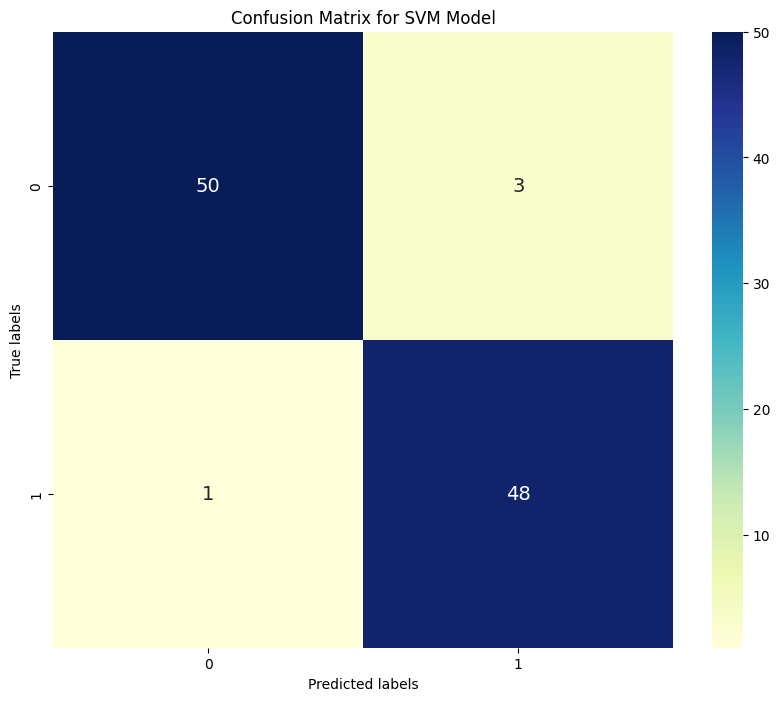

In [101]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Your SVC classifier code
clf = SVC(kernel='linear', random_state=0)
clf.fit(X_train_2d, y_train)
y_pred = clf.predict(X_test_2d)

print('---------- Support Vector Machine Classifier Model - Evaluation on Test Data ----------')
# Printing classification report
print(classification_report(y_test, y_pred))

# Creating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=clf.classes_, yticklabels=clf.classes_, annot_kws={"size": 14})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for SVM Model')
plt.show()


---------- Logistic Regression Classifier Model - Evaluation on Test Data ----------
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        53
           1       0.94      0.96      0.95        49

    accuracy                           0.95       102
   macro avg       0.95      0.95      0.95       102
weighted avg       0.95      0.95      0.95       102



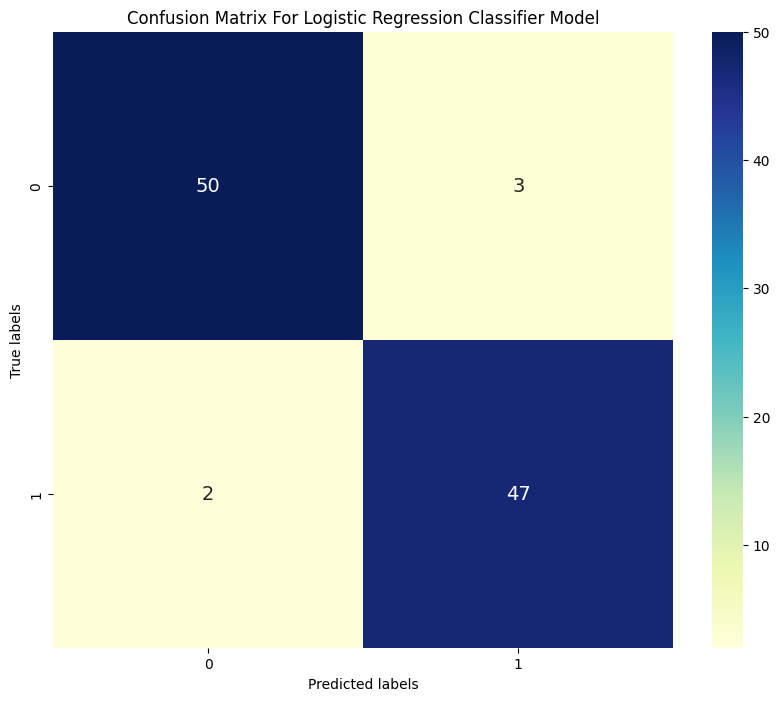

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Your Logistic Regression classifier code
clf = LogisticRegression(random_state=0, solver='newton-cg')
clf.fit(X_train_2d, y_train)
y_pred = clf.predict(X_test_2d)

print('---------- Logistic Regression Classifier Model - Evaluation on Test Data ----------')
# Printing classification report
print(classification_report(y_test, y_pred))

# Creating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=clf.classes_, yticklabels=clf.classes_, annot_kws={"size": 14})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix For Logistic Regression Classifier Model')
plt.show()



---------- Decision Tree Classifier Model - Evaluation on Test Data ----------
              precision    recall  f1-score   support

           0       0.90      0.81      0.85        53
           1       0.81      0.90      0.85        49

    accuracy                           0.85       102
   macro avg       0.86      0.85      0.85       102
weighted avg       0.86      0.85      0.85       102



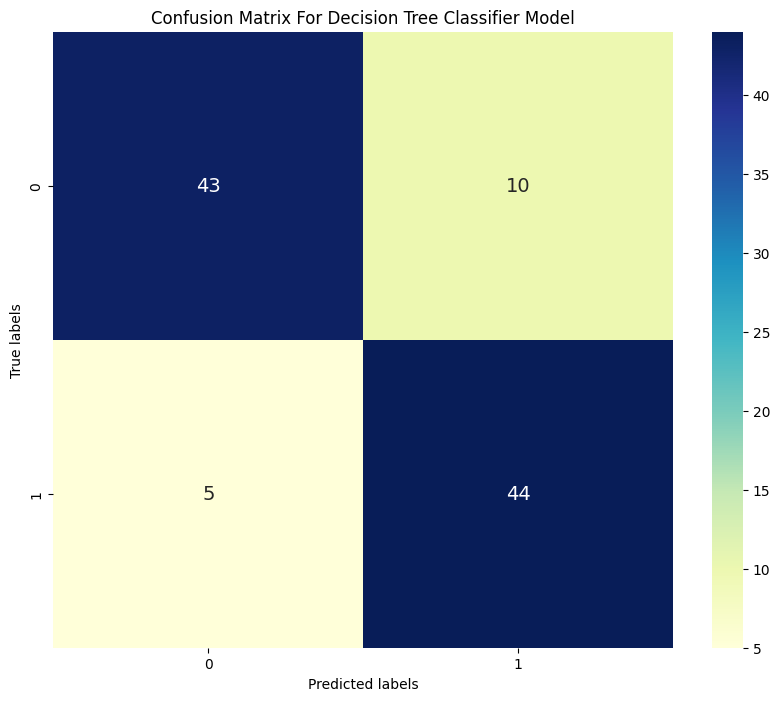

In [103]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=0)

# Train the classifier
clf.fit(X_train_2d, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_2d)

print('---------- Decision Tree Classifier Model - Evaluation on Test Data ----------')
# Printing classification report
print(classification_report(y_test, y_pred))

# Creating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=clf.classes_, yticklabels=clf.classes_, annot_kws={"size": 14})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix For Decision Tree Classifier Model')
plt.show()


In [35]:
# Load the unlabeled dataset
unlabeled_file_path = "//content//drive//MyDrive//Metaphor Detector//Unlabel.csv"
df_unlabeled = pd.read_csv(unlabeled_file_path, encoding='ISO-8859-1')

In [36]:
df_unlabeled.shape

(14994, 1)

In [37]:
# Function to map HPSM and LPSM based on the presence of 'like' or 'as' in the excerpt
def map_markers(excerpt):
    # Define regular expressions to match 'like' and 'as' as standalone words
    like_regex = r'\blike\b'
    as_regex = r'\bas\b'

    # Search for 'like' and 'as' as standalone words in the excerpt
    if re.search(like_regex, excerpt, flags=re.IGNORECASE):
        hpsm = 'the LIKE word present'
        lpsm = 'direct comparison'
    elif re.search(as_regex, excerpt, flags=re.IGNORECASE):
        hpsm = 'the AS word present'
        lpsm = 'direct comparison'
    else:
        hpsm = ''
        lpsm = ''
    return hpsm, lpsm

# Apply the function to the 'Excerpt' column
df_unlabeled['HPSM'], df_unlabeled['LPSM'] = zip(*df_unlabeled['Excerpt'].apply(map_markers))

# Save the updated dataset
updated_unlabeled_file_path = "//content//drive//MyDrive//Metaphor Detector//updated_unlabeled.csv"
df_unlabeled.to_csv(updated_unlabeled_file_path, index=False)

In [38]:
df_unlabeled.shape

(14994, 3)

In [39]:
# Function to calculate cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Function to extract different pairs from the excerpt
def extract_pairs(excerpt):
    doc = nlp(excerpt)
    pairs = {'noun_noun_pairs': [], 'adjective_noun_pairs': [], 'adverb_adjective_pairs': []}

    # Extract noun-noun pairs
    for token in doc:
        if token.pos_ == 'NOUN' and token.head.pos_ == 'NOUN':
            pairs['noun_noun_pairs'].append((token, token.head))

    # Extract adjective-noun pairs
    for token in doc:
        if token.pos_ == 'ADJ' and token.head.pos_ == 'NOUN':
            pairs['adjective_noun_pairs'].append((token, token.head))

    # Extract adverb-adjective pairs
    for token in doc:
        if token.pos_ == 'ADV' and token.head.pos_ == 'ADJ':
            pairs['adverb_adjective_pairs'].append((token, token.head))

    return pairs

# Function to identify pairs with high dissimilarity
def identify_pairs_with_dissimilarity(pairs, threshold=0.5):
    concept_pairs = defaultdict(list)

    for pair_type, pair_list in pairs.items():
        for pair in pair_list:
            similarity_score = cosine_similarity(pair[0].vector, pair[1].vector)
            if similarity_score < threshold:
                concept_pairs[similarity_score].append(pair)

    if concept_pairs:
        selected_pairs = concept_pairs[max(concept_pairs.keys())]
    else:
        selected_pairs = []

    return selected_pairs

# Function to augment the Concepts column
def augment_concepts(excerpt, threshold=0.5):
    pairs = extract_pairs(excerpt)
    selected_pairs = identify_pairs_with_dissimilarity(pairs, threshold)
    augmented_concepts = []

    for pair in selected_pairs:
        concept_pair = [pair[0], pair[1]]
        noun_concepts = [token.lemma_ for token in concept_pair]
        augmented_concepts.extend(noun_concepts)

    return augmented_concepts

# Apply the augmentation process to the Concepts column in the unlabeled dataset
df_unlabeled['Concepts'] = df_unlabeled['Excerpt'].apply(lambda x: augment_concepts(x, threshold=0.6))

# Remove duplicates and convert list of concepts to string
df_unlabeled['Concepts'] = df_unlabeled['Concepts'].apply(lambda x: ', '.join(set(x)))

# Save the updated dataset to a new file
df_unlabeled.to_csv('updated_unlabeled.csv', index=False)

In [40]:
# Load the unlabeled dataset
unlabeled_file_path = "//content//drive//MyDrive//Metaphor Detector//updated_unlabeled.csv"
df_unlabeled = pd.read_csv(unlabeled_file_path, encoding='ISO-8859-1')

# Function to extract metaphorical pairs from an excerpt
def extract_metaphorical_pairs(excerpt):
    doc = nlp(excerpt)
    metaphorical_pairs = []

    for i, token in enumerate(doc):
        if i < len(doc) - 2:
            if token.dep_ == 'prep' and doc[i+1].dep_ == 'pobj':
                metaphorical_pairs.append((token.head.text, doc[i+1].text))
            elif token.text.lower() in ['like', 'as'] and doc[i+1].dep_ == 'nsubj' and doc[i+2].dep_ == 'acomp':
                metaphorical_pairs.append((doc[i+1].text, doc[i+2].text))

    return ', '.join([' '.join(pair) for pair in metaphorical_pairs])

# Function to extract noun entities from an excerpt
def extract_noun_entities(excerpt):
    doc = nlp(excerpt)
    noun_entities = [chunk.text for chunk in doc.noun_chunks]
    return ', '.join(noun_entities)

# Apply both functions to each excerpt in the Concepts column where the value is NaN
nan_rows = df_unlabeled[df_unlabeled['Concepts'].isna()]
nan_rows['Concepts'] = nan_rows['Excerpt'].apply(extract_noun_entities) + ', ' + nan_rows['Excerpt'].apply(extract_metaphorical_pairs)

# Update the NaN values in the original DataFrame with the extracted values
df_unlabeled.update(nan_rows)

<ipython-input-40-db8aecf274ae>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_rows['Concepts'] = nan_rows['Excerpt'].apply(extract_noun_entities) + ', ' + nan_rows['Excerpt'].apply(extract_metaphorical_pairs)


In [41]:
# Replace missing values in HPSM and LPSM columns with 'Unknown'
df_unlabeled['HPSM'] = df_unlabeled['HPSM'].fillna('Unknown')
df_unlabeled['LPSM'] = df_unlabeled['LPSM'].fillna('Unknown')

# Save the updated dataset
updated_file_path = "//content//drive//MyDrive//Metaphor Detector//updated_unlabeled3.csv"
df_unlabeled.to_csv(updated_file_path, index=False)

In [42]:
df_unlabeled.shape

(14994, 4)

In [43]:
# Check if any NaN values exist in the DataFrame
if df_unlabeled.isna().any().any():
    print("DataFrame contains NaN values")
else:
    print("DataFrame does not contain any NaN values")

DataFrame does not contain any NaN values


In [44]:
df_unlabeled.head()

,Excerpt,HPSM,LPSM,Concepts
0,"Master, if yesterday was dead,",Unknown,Unknown,"Master, yesterday,"
1,I could still remember how I folded my knees,Unknown,Unknown,"I, I, my knees,"
2,On the mocking face of the sand,Unknown,Unknown,"mocking, face"
3,To wash your filthy feet,Unknown,Unknown,"filthy, foot"
4,"My devotion dwarfed me,",Unknown,Unknown,"My devotion, me,"


In [46]:
# Preprocess 'Excerpt' column
preprocessed_excerpt = []
for text in df_unlabeled['Excerpt']:
    preprocessed_text = preprocess_text(str(text))
    preprocessed_excerpt.append(preprocessed_text)
df_unlabeled['Preprocessed_Excerpt'] = preprocessed_excerpt

# Preprocess 'HPSM' column
preprocessed_hpsm = []
for text in df_unlabeled['HPSM']:
    preprocessed_text = preprocess_text(str(text))
    preprocessed_hpsm.append(preprocessed_text)
df_unlabeled['Preprocessed_HPSM'] = preprocessed_hpsm

# Preprocess 'LPSM' column
preprocessed_lpsm = []
for text in df_unlabeled['LPSM']:
    preprocessed_text = preprocess_text(str(text))
    preprocessed_lpsm.append(preprocessed_text)
df_unlabeled['Preprocessed_LPSM'] = preprocessed_lpsm

# Preprocess 'Concepts' column
preprocessed_concepts = []
for text in df_unlabeled['Concepts']:
    preprocessed_text = preprocess_text(str(text))
    preprocessed_concepts.append(preprocessed_text)
df_unlabeled['Preprocessed_Concepts'] = preprocessed_concepts

In [47]:
# Apply the function to the newly created preprocessed columns in unlabeled dataset
df_unlabeled['Preprocessed_Excerpt'] = df_unlabeled['Preprocessed_Excerpt'].apply(remove_symbols)
df_unlabeled['Preprocessed_HPSM'] = df_unlabeled['Preprocessed_HPSM'].apply(remove_symbols)
df_unlabeled['Preprocessed_LPSM'] = df_unlabeled['Preprocessed_LPSM'].apply(remove_symbols)
df_unlabeled['Preprocessed_Concepts'] = df_unlabeled['Preprocessed_Concepts'].apply(remove_symbols)

In [48]:
df_unlabeled.head()

,Excerpt,HPSM,LPSM,Concepts,Preprocessed_Excerpt,Preprocessed_HPSM,Preprocessed_LPSM,Preprocessed_Concepts
0,"Master, if yesterday was dead,",Unknown,Unknown,"Master, yesterday,",master if yesterday be dead,unknown,unknown,master yesterday
1,I could still remember how I folded my knees,Unknown,Unknown,"I, I, my knees,",i could still remember how i fold my knee,unknown,unknown,i i my knee
2,On the mocking face of the sand,Unknown,Unknown,"mocking, face",on the mocking face of the sand,unknown,unknown,mocking face
3,To wash your filthy feet,Unknown,Unknown,"filthy, foot",to wash your filthy foot,unknown,unknown,filthy foot
4,"My devotion dwarfed me,",Unknown,Unknown,"My devotion, me,",my devotion dwarf i,unknown,unknown,my devotion i


In [49]:
# Concatenate the specified columns into one
df_unlabeled['Concatenated_Column'] = df_unlabeled.apply(lambda row: ' '.join(row[col] for col in ['Preprocessed_Excerpt', 'Preprocessed_HPSM', 'Preprocessed_LPSM', 'Preprocessed_Concepts']), axis=1)

In [50]:
df_unlabeled.head()

,Excerpt,HPSM,LPSM,Concepts,Preprocessed_Excerpt,Preprocessed_HPSM,Preprocessed_LPSM,Preprocessed_Concepts,Concatenated_Column
0,"Master, if yesterday was dead,",Unknown,Unknown,"Master, yesterday,",master if yesterday be dead,unknown,unknown,master yesterday,master if yesterday be dead unknown unknown ma...
1,I could still remember how I folded my knees,Unknown,Unknown,"I, I, my knees,",i could still remember how i fold my knee,unknown,unknown,i i my knee,i could still remember how i fold my knee unkn...
2,On the mocking face of the sand,Unknown,Unknown,"mocking, face",on the mocking face of the sand,unknown,unknown,mocking face,on the mocking face of the sand unknown unknow...
3,To wash your filthy feet,Unknown,Unknown,"filthy, foot",to wash your filthy foot,unknown,unknown,filthy foot,to wash your filthy foot unknown unknown filth...
4,"My devotion dwarfed me,",Unknown,Unknown,"My devotion, me,",my devotion dwarf i,unknown,unknown,my devotion i,my devotion dwarf i unknown unknown my devotion i


In [51]:
# Preprocess 'Concatenated_Column' column in labeled dataframe
df_unlabeled['vector'] = df_unlabeled['Concatenated_Column'].apply(lambda x: nlp(x).vector)

In [52]:
df_unlabeled.head()

,Excerpt,HPSM,LPSM,Concepts,Preprocessed_Excerpt,Preprocessed_HPSM,Preprocessed_LPSM,Preprocessed_Concepts,Concatenated_Column,vector
0,"Master, if yesterday was dead,",Unknown,Unknown,"Master, yesterday,",master if yesterday be dead,unknown,unknown,master yesterday,master if yesterday be dead unknown unknown ma...,"[-2.4070532, 0.33717337, -0.3371222, -0.794602..."
1,I could still remember how I folded my knees,Unknown,Unknown,"I, I, my knees,",i could still remember how i fold my knee,unknown,unknown,i i my knee,i could still remember how i fold my knee unkn...,"[2.3369968, 2.2934527, -3.2453165, -4.069793, ..."
2,On the mocking face of the sand,Unknown,Unknown,"mocking, face",on the mocking face of the sand,unknown,unknown,mocking face,on the mocking face of the sand unknown unknow...,"[-2.6117454, 0.9336291, -1.3350625, 1.7318181,..."
3,To wash your filthy feet,Unknown,Unknown,"filthy, foot",to wash your filthy foot,unknown,unknown,filthy foot,to wash your filthy foot unknown unknown filth...,"[0.61634225, 5.3975887, -3.2170665, -1.4505677..."
4,"My devotion dwarfed me,",Unknown,Unknown,"My devotion, me,",my devotion dwarf i,unknown,unknown,my devotion i,my devotion dwarf i unknown unknown my devotion i,"[1.7732377, 0.17043334, -3.1582887, -4.4403896..."


In [55]:
X_unlabeled = df_unlabeled.vector.values

In [56]:
X_unlabeled

array([array([-2.4070532e+00,  3.3717337e-01, -3.3712220e-01, -7.9460216e-01,
               3.9892000e-01,  8.9714199e-01,  6.4387107e-01,  3.5104887e+00,
              -3.0336332e-01,  1.6444999e+00,  3.7596757e+00, -2.5567127e-02,
              -1.3564000e+00,  3.7279555e-01,  1.7908478e+00, -4.8890910e-01,
               1.5737290e+00, -1.8590379e+00, -2.3038754e+00, -1.6514888e+00,
               1.7120444e+00, -2.1780467e+00, -8.1400096e-01, -1.4473327e-01,
              -8.8715041e-01, -8.2717109e-01, -1.8961517e+00, -2.0589111e+00,
              -1.8977669e-01,  7.0041883e-01,  1.3871112e+00, -1.5277156e+00,
              -4.5036449e+00, -2.1608001e-01, -1.7026559e-01, -2.1518722e+00,
              -1.4488556e+00,  1.2312121e+00,  2.6153173e+00,  4.1582441e-01,
              -1.9709778e+00,  1.5309224e+00,  1.1359046e+00,  1.2375890e+00,
               3.6812443e-01,  3.8866222e-01,  1.5831754e+00, -5.8335357e+00,
              -1.4867624e+00,  1.9212000e+00,  2.2216670e-01,  1

In [57]:
X_unlabeled_2d = np.stack(X_unlabeled)

In [58]:
X_unlabeled_2d

array([[-2.4070532 ,  0.33717337, -0.3371222 , ...,  1.4443799 ,
        -1.3535821 ,  2.2957664 ],
       [ 2.3369968 ,  2.2934527 , -3.2453165 , ..., -1.2786638 ,
        -7.422916  ,  0.9377206 ],
       [-2.6117454 ,  0.9336291 , -1.3350625 , ..., -1.6707093 ,
        -1.9597491 , -1.0399346 ],
       ...,
       [-0.4027543 ,  2.9356215 ,  0.44607145, ...,  1.0666858 ,
        -5.6625724 ,  2.1080472 ],
       [-1.5948046 ,  2.9383616 , -1.3651214 , ...,  1.383863  ,
        -4.2309613 ,  1.0835992 ],
       [-2.1248908 ,  1.4577472 , -1.6582575 , ..., -0.53707343,
        -4.571276  ,  0.16844754]], dtype=float32)

In [59]:
X_unlabeled_2d.shape

(14994, 300)

---------- Support Vector Machine - SSL Approach ----------
Final model accuracy on the test set: 0.803921568627451
Classification report on the test set:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        53
           1       0.78      0.82      0.80        49

    accuracy                           0.80       102
   macro avg       0.80      0.80      0.80       102
weighted avg       0.80      0.80      0.80       102

Classes: [0 1]
Number of Iterations: [2964]


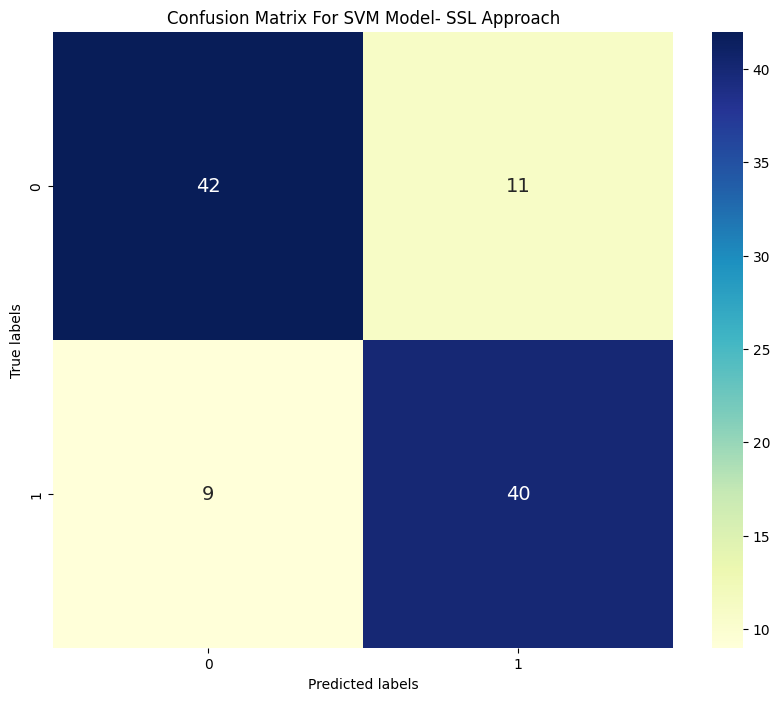

In [93]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize SVM classifier
svm_clf = SVC(kernel='linear', random_state=42)

# Define initial labeled data
labeled_subset_size = len(X_train_2d) // 5
X_labeled = X_train_2d[:labeled_subset_size]
y_labeled = y_train[:labeled_subset_size]

# Define initial unlabeled data
X_unlabeled_reshaped = X_unlabeled_2d

# Train the initial model with labeled data
svm_clf.fit(X_labeled, y_labeled)

# Iteratively improve the model
while True:
    # Use the model to predict pseudo-labels for unlabeled data
    y_pred_unlabeled = svm_clf.predict(X_unlabeled_reshaped)

    # Find confident predictions (above threshold)
    confident_predictions_mask = svm_clf.decision_function(X_unlabeled_reshaped) >= 0.7

    if not confident_predictions_mask.any():
        break  # No confident predictions, stop iterating

    # Add confident predictions to labeled data
    X_labeled = np.concatenate([X_labeled, X_unlabeled_reshaped[confident_predictions_mask]])
    y_labeled = np.concatenate([y_labeled, y_pred_unlabeled[confident_predictions_mask]])

    # Remove confident predictions from unlabeled data
    X_unlabeled_reshaped = X_unlabeled_reshaped[~confident_predictions_mask]

    # Train the model with the updated labeled data
    svm_clf.fit(X_labeled, y_labeled)

# Evaluate on the test set
y_pred_test = svm_clf.predict(X_test_2d)
accuracy = accuracy_score(y_test, y_pred_test)

print("---------- Support Vector Machine - SSL Approach ----------")
print("Final model accuracy on the test set:", accuracy)

# Obtain classification report
print("Classification report on the test set:")
print(classification_report(y_test, y_pred_test))

# Additional information about the model
print("Classes:", svm_clf.classes_)
print("Number of Iterations:", svm_clf.n_iter_)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=svm_clf.classes_, yticklabels=svm_clf.classes_, annot_kws={"size": 14})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix For SVM Model- SSL Approach')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

---------- Logistic Regression Classifier - SSL Approach ----------
Final model accuracy on the test set: 0.9313725490196079
Classification report on the test set:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        53
           1       0.92      0.94      0.93        49

    accuracy                           0.93       102
   macro avg       0.93      0.93      0.93       102
weighted avg       0.93      0.93      0.93       102

Classes: [0 1]
Number of Iterations: [100]


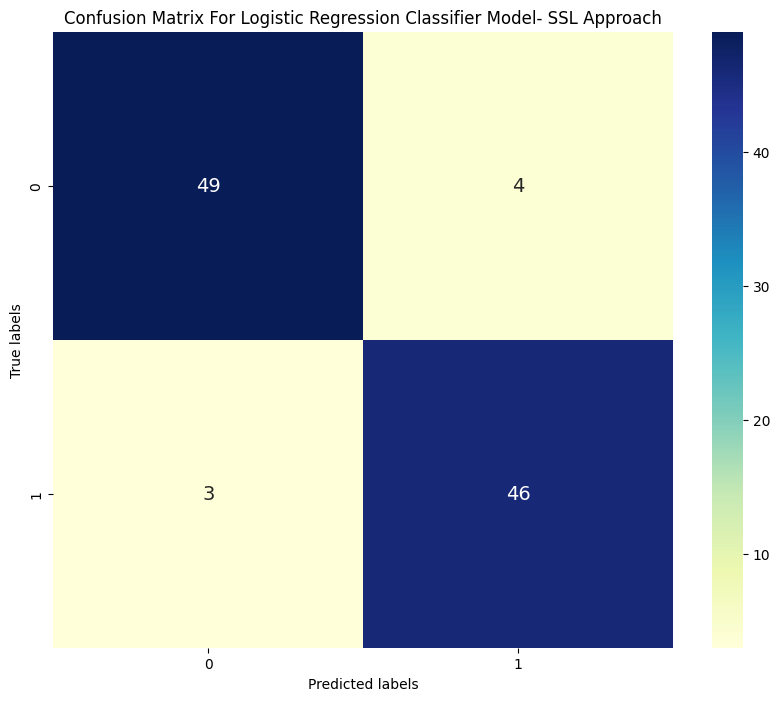

In [94]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Logistic Regression classifier
log_reg_clf = LogisticRegression(random_state=42)

# Define initial labeled data
labeled_subset_size = len(X_train_2d) // 5
X_labeled = X_train_2d[:labeled_subset_size]
y_labeled = y_train[:labeled_subset_size]

# Define initial unlabeled data
X_unlabeled_reshaped = X_unlabeled_2d

# Train the initial model with labeled data
log_reg_clf.fit(X_labeled, y_labeled)

# Iteratively improve the model
while True:
    # Use the model to predict pseudo-labels for unlabeled data
    y_pred_unlabeled = log_reg_clf.predict(X_unlabeled_reshaped)

    # Find confident predictions (above threshold)
    confident_predictions_mask = log_reg_clf.predict_proba(X_unlabeled_reshaped).max(axis=1) >= 0.7

    if not confident_predictions_mask.any():
        break  # No confident predictions, stop iterating

    # Add confident predictions to labeled data
    X_labeled = np.concatenate([X_labeled, X_unlabeled_reshaped[confident_predictions_mask]])
    y_labeled = np.concatenate([y_labeled, y_pred_unlabeled[confident_predictions_mask]])

    # Remove confident predictions from unlabeled data
    X_unlabeled_reshaped = X_unlabeled_reshaped[~confident_predictions_mask]

    # Train the model with the updated labeled data
    log_reg_clf.fit(X_labeled, y_labeled)

# Evaluate on the test set
y_pred_test = log_reg_clf.predict(X_test_2d)
accuracy = accuracy_score(y_test, y_pred_test)
print("---------- Logistic Regression Classifier - SSL Approach ----------")
print("Final model accuracy on the test set:", accuracy)

# Obtain classification report
print("Classification report on the test set:")
print(classification_report(y_test, y_pred_test))

# Additional information about the model
print("Classes:", log_reg_clf.classes_)
print("Number of Iterations:", log_reg_clf.n_iter_)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=log_reg_clf.classes_, yticklabels=log_reg_clf.classes_, annot_kws={"size": 14})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix For Logistic Regression Classifier Model- SSL Approach')
plt.show()

---------- K-Neighbors Classifier - SSL Approach ----------
Final model accuracy on the test set: 0.8627450980392157
Classification report on the test set:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86        53
           1       0.82      0.92      0.87        49

    accuracy                           0.86       102
   macro avg       0.87      0.86      0.86       102
weighted avg       0.87      0.86      0.86       102

Classes: [0 1]


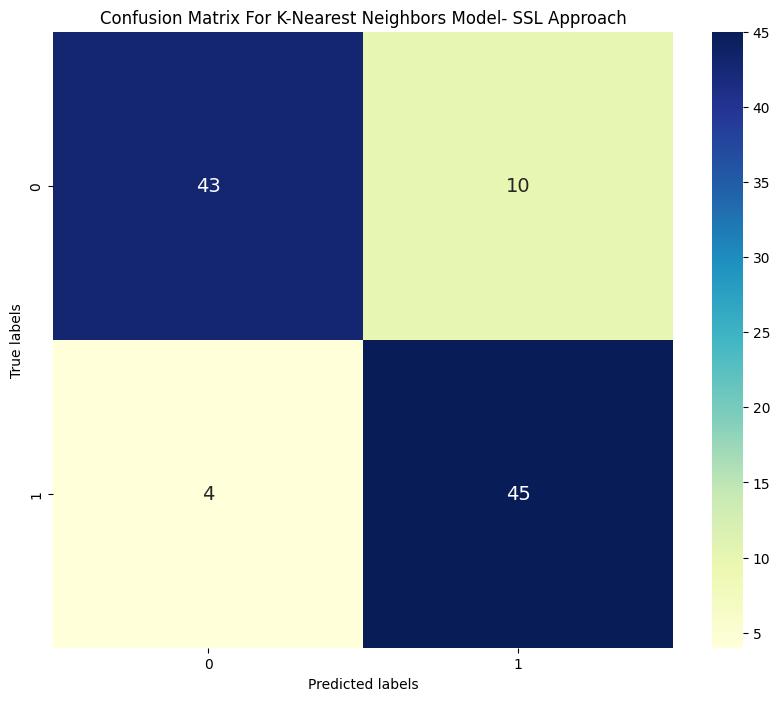

In [96]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize KNN classifier
knn_clf = KNeighborsClassifier()

# Define initial labeled data
labeled_subset_size = len(X_train_2d) // 10
X_labeled = X_train_2d[:labeled_subset_size]
y_labeled = y_train[:labeled_subset_size]

# Define initial unlabeled data
X_unlabeled_reshaped = X_unlabeled_2d

# Train the initial model with labeled data
knn_clf.fit(X_labeled, y_labeled)

# Iteratively improve the model
while True:
    # Use the model to predict pseudo-labels for unlabeled data
    y_pred_unlabeled = knn_clf.predict(X_unlabeled_reshaped)

    # Find confident predictions (above threshold)
    confident_predictions_mask = knn_clf.predict_proba(X_unlabeled_reshaped).max(axis=1) >= 0.7

    if not confident_predictions_mask.any():
        break  # No confident predictions, stop iterating

    # Add confident predictions to labeled data
    X_labeled = np.concatenate([X_labeled, X_unlabeled_reshaped[confident_predictions_mask]])
    y_labeled = np.concatenate([y_labeled, y_pred_unlabeled[confident_predictions_mask]])

    # Remove confident predictions from unlabeled data
    X_unlabeled_reshaped = X_unlabeled_reshaped[~confident_predictions_mask]

    # Train the model with the updated labeled data
    knn_clf.fit(X_labeled, y_labeled)

# Evaluate on the test set
y_pred_test = knn_clf.predict(X_test_2d)
accuracy = accuracy_score(y_test, y_pred_test)
print("---------- K-Neighbors Classifier - SSL Approach ----------")
print("Final model accuracy on the test set:", accuracy)

# Obtain classification report
print("Classification report on the test set:")
print(classification_report(y_test, y_pred_test))

# Additional information about the model
print("Classes:", knn_clf.classes_)


# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=knn_clf.classes_, yticklabels=knn_clf.classes_, annot_kws={"size": 14})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix For K-Nearest Neighbors Model- SSL Approach')
plt.show()



---------- DecisionTreeClassifier - SSL Approach ----------
Final model accuracy on the test set: 0.7941176470588235
Classification report on the test set:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        53
           1       0.80      0.76      0.78        49

    accuracy                           0.79       102
   macro avg       0.80      0.79      0.79       102
weighted avg       0.79      0.79      0.79       102

Classes: [0 1]
Number of iterations: 101


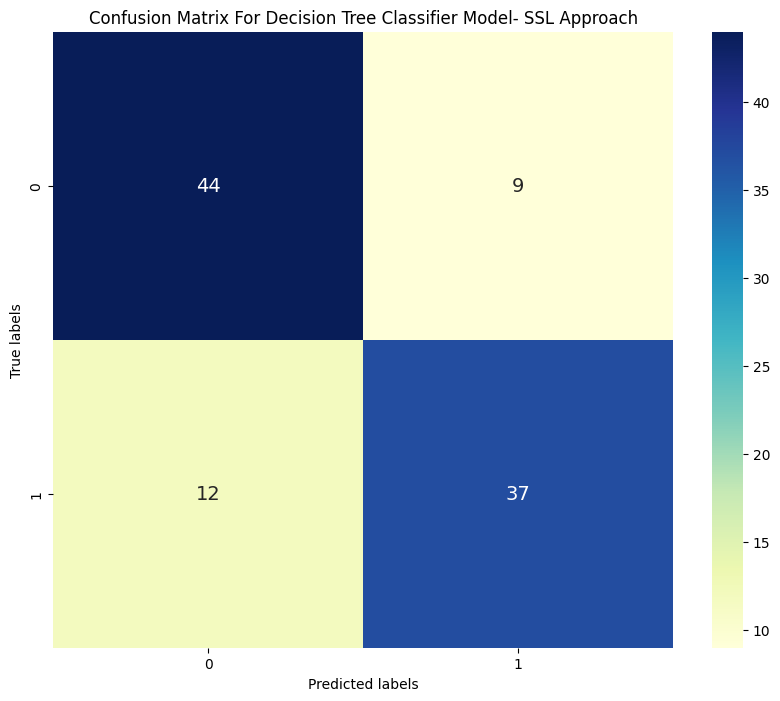

In [99]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Decision Tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Define initial labeled data
labeled_subset_size = len(X_train_2d) // 5
X_labeled = X_train_2d[:labeled_subset_size]
y_labeled = y_train[:labeled_subset_size]

# Define initial unlabeled data
X_unlabeled_reshaped = X_unlabeled_2d

# Counter variable to keep track of iterations
num_iterations = 100

# Train the initial model with labeled data
dt_clf.fit(X_labeled, y_labeled)

# Iteratively improve the model
while True:
    # Check if there are any unlabeled instances left
    if len(X_unlabeled_reshaped) == 0:
        break

    # Use the model to predict pseudo-labels for unlabeled data
    y_pred_unlabeled = dt_clf.predict(X_unlabeled_reshaped)

    # Find confident predictions (above threshold)
    confident_predictions_mask = dt_clf.predict_proba(X_unlabeled_reshaped).max(axis=1) >= 0.7

    if not confident_predictions_mask.any():
        break  # No confident predictions, stop iterating

    # Add confident predictions to labeled data
    X_labeled = np.concatenate([X_labeled, X_unlabeled_reshaped[confident_predictions_mask]])
    y_labeled = np.concatenate([y_labeled, y_pred_unlabeled[confident_predictions_mask]])

    # Remove confident predictions from unlabeled data
    X_unlabeled_reshaped = X_unlabeled_reshaped[~confident_predictions_mask]

    # Train the model with the updated labeled data
    dt_clf.fit(X_labeled, y_labeled)

    # Increment the number of iterations
    num_iterations += 1

# Evaluate on the test set if there are test instances available
if len(X_test_2d) > 0:
    y_pred_test = dt_clf.predict(X_test_2d)
    accuracy = accuracy_score(y_test, y_pred_test)
    print("---------- DecisionTreeClassifier - SSL Approach ----------")
    print("Final model accuracy on the test set:", accuracy)

    # Obtain classification report
    print("Classification report on the test set:")
    print(classification_report(y_test, y_pred_test))

    # Additional information about the model
    print("Classes:", dt_clf.classes_)
    # Print the number of iterations
    print("Number of iterations:", num_iterations)


    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=dt_clf.classes_, yticklabels=dt_clf.classes_, annot_kws={"size": 14})
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix For Decision Tree Classifier Model- SSL Approach')
    plt.show()
else:
    print("No test instances available for evaluation.")